# Set Up

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# change to your working directory
#%cd "/content/drive/MyDrive/shared folder/Master_Thesis"
%cd "/content/drive/MyDrive/shared_folder/Master_Thesis" 

/content/drive/.shortcut-targets-by-id/1lHcON5EHJDerZlJ2mPUGsY4w6iFLBKs5/shared_folder/Master_Thesis


In [ ]:
!pip install adapt

In [ ]:
import os, random, shutil, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from PIL import Image

from sklearn.preprocessing import OneHotEncoder
from sklearn.manifold import TSNE

import tensorflow as tf
from tensorflow.keras import Model, Sequential
from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adagrad
from tensorflow.keras.layers import Dense, Input, Dropout, Conv2D, MaxPooling2D, Flatten, Reshape, GaussianNoise 
from tensorflow.keras.layers import BatchNormalization,  GlobalMaxPooling2D, GlobalAveragePooling2D,  Add
from tensorflow.keras.applications import VGG16, InceptionV3, ResNet50, ResNet50V2, MobileNetV3Large
from tensorflow.keras.constraints import MinMaxNorm, MaxNorm
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model, load_model
from keras.preprocessing.image import load_img, img_to_array, array_to_img
from tensorflow.keras.optimizers.schedules import LearningRateSchedule

from adapt.parameter_based import FineTuning
from adapt.feature_based import MDD
from adapt.utils import UpdateLambda

In [ ]:
print("GPU Available: ", tf.test.is_gpu_available())
print(tf.__version__)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU Available:  True
2.8.0


In [ ]:
# Original Dataset
Source_dir_train1 = "./Images/DANN/Source/LC25000_mix_data_128_train1.pkl"
Source_dir_train2 = "./Images/DANN/Source/LC25000_mix_data_128_train2.pkl"
Source_dir_train3 = "./Images/DANN/Source/LC25000_mix_data_128_train3.pkl"
Source_dir_train4 = "./Images/DANN/Source/LC25000_mix_data_128_train4.pkl"
Source_dir_train5 = "./Images/DANN/Source/LC25000_mix_data_128_train5.pkl"
Source_dir_test1 = "./Images/DANN/Source/LC25000_mix_data_128_test1.pkl"
Source_dir_test2 = "./Images/DANN/Source/LC25000_mix_data_128_test2.pkl"


Target_dir_train = os.path.abspath("./Images/DANN/Target/TCGA_mix_data_128_train.pkl")
Target_dir_test = os.path.abspath("./Images/DANN/Target/TCGA_mix_data_128_test.pkl")

# Cyclegan Dataset

Target_cyclegan_dir_train = os.path.abspath("./Images/DANN/Target_cyclegan/TCGA_cyclegan_mix_data_128_train.pkl")
Target_cyclegan_dir_test = os.path.abspath("./Images/DANN/Target_cyclegan/TCGA_cyclegan_mix_data_128_test.pkl")

In [ ]:
BATCH_SIZE = 64
CHANNELS = 3
IMAGE_HEIGHT = 128
IMAGE_WIDTH = 128
EPOCH = 5

# Loading Dataset

## configuration

In [ ]:
#rescale
def convert(data_list):
    for i in range(len(data_list)): data_list[i]=data_list[i]/255

In [ ]:
# Data Augmentation
def augment(image):
    image = np.array(image, dtype=np.float32)
    #image = (image / 255.0)
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.15, seed=1)
    image = tf.image.random_hue(image, max_delta=0.09, seed=1)
    return image

def augment_1(image):
    image = np.array(image, dtype=np.float32)
    image = (image / 255.0)
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.15, seed=1)
    image = tf.image.random_hue(image, max_delta=0.09, seed=1)
    return image

# process dataset
def data_augmentation(dataset):
    au=[]
    for file in dataset:
        file_au = augment(file)
        au.append(file_au)
    return au

## LC25000 Data Augmentation Dataset

In [ ]:
# LC25000 Dataset
with open(os.path.abspath(Source_dir_train1), "rb") as f:
    LC25000_train1 = pickle.load(f)
with open(os.path.abspath(Source_dir_train2), "rb") as f:
    LC25000_train2 = pickle.load(f)
with open(os.path.abspath(Source_dir_train3), "rb") as f:
    LC25000_train3 = pickle.load(f)
with open(os.path.abspath(Source_dir_train4), "rb") as f:
    LC25000_train4 = pickle.load(f)
with open(os.path.abspath(Source_dir_train5), "rb") as f:
    LC25000_train5 = pickle.load(f)
with open(os.path.abspath(Source_dir_test1), "rb") as f:
    LC25000_test1 = pickle.load(f)
with open(os.path.abspath(Source_dir_test2), "rb") as f:
    LC25000_test2 = pickle.load(f)

In [ ]:
LC25000_train_data = LC25000_train1['train'] + LC25000_train2['train'] + LC25000_train3['train'] + LC25000_train4['train'] + LC25000_train5['train']
LC25000_train_labels = np.concatenate((LC25000_train1['train_label'],LC25000_train2['train_label'],LC25000_train3['train_label'],LC25000_train4['train_label'],LC25000_train5['train_label']))
LC25000_test_data = LC25000_test1['test'] + LC25000_test2['test']
LC25000_test_labels = np.concatenate((LC25000_test1['test_label'],LC25000_test2['test_label']))

In [ ]:
LC25000_train_lab = tf.one_hot(LC25000_train_labels, depth=3)
LC25000_test_lab = tf.one_hot(LC25000_test_labels, depth=3)

### Data Augmentation Process

In [ ]:
LC25000_train_data_au = data_augmentation(LC25000_train_data)
LC25000_test_data_au = data_augmentation(LC25000_test_data)

In [ ]:
LC25000_train_data_au = np.array(LC25000_train_data_au, dtype=np.float32)
LC25000_test_data_au = np.array(LC25000_test_data_au, dtype=np.float32)

In [ ]:
print("The shape of LC25000_train_data: ", LC25000_train_data_au.shape)
print("The shape of LC25000_train_labels: ", LC25000_train_labels.shape)
print("The shape of LC25000_test_data: ", LC25000_test_data_au.shape)
print("The shape of LC25000_test_labels: " ,LC25000_test_labels.shape)

The shape of LC25000_train_data:  (6400, 128, 128, 3)
The shape of LC25000_train_labels:  (6400,)
The shape of LC25000_test_data:  (1600, 128, 128, 3)
The shape of LC25000_test_labels:  (1600,)


In [ ]:
import gc
gc.collect()

125

## TCGA Dataset

In [ ]:
# TCGA Dataset
with open(os.path.abspath(Target_dir_train), "rb") as f:
    TCGA_train = pickle.load(f)
with open(os.path.abspath(Target_dir_test), "rb") as f:
    TCGA_test = pickle.load(f)

In [ ]:
TCGA_train_data = TCGA_train['train']
TCGA_train_labels = TCGA_train['train_label']
TCGA_test_data = TCGA_test['test']
TCGA_test_labels = TCGA_test['test_label']

In [ ]:
TCGA_train_lab = tf.one_hot(TCGA_train_labels, depth=3)
TCGA_test_lab = tf.one_hot(TCGA_test_labels, depth=3)
TCGA_train_data = np.array(TCGA_train_data, dtype=np.float32)
TCGA_test_data = np.array(TCGA_test_data, dtype=np.float32)

In [ ]:
print("The shape of TCGA_train_data: ", np.shape(TCGA_train_data))
print("The shape of TCGA_train_labels: ", np.shape(TCGA_train_labels))
print("The shape of TCGA_test_data: ", np.shape(TCGA_test_data))
print("The shape of TCGA_test_labels: " , np.shape(TCGA_test_labels))

The shape of TCGA_train_data:  (6400, 128, 128, 3)
The shape of TCGA_train_labels:  (6400,)
The shape of TCGA_test_data:  (6400, 128, 128, 3)
The shape of TCGA_test_labels:  (6400,)


In [ ]:
import gc
gc.collect()

200

## Datasets Visualization

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


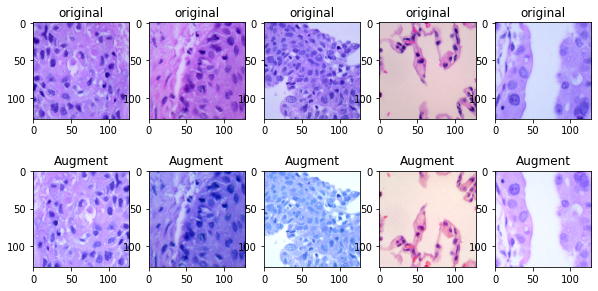

In [ ]:
# show the difference bewteen Original images and Data Augmentation images
fig = plt.figure(figsize=(10, 10))

for i in range(5):
    sample = random.choice(LC25000_train_data)
    fig.add_subplot(2,5,i+1)
    img = array_to_img(sample)
    plt.title("original")
    plt.imshow(img)
    fig.add_subplot(1,5,i+1)
    img1 = augment_1(sample)
    plt.title("Augment")
    plt.imshow(img1)

<function matplotlib.pyplot.show>

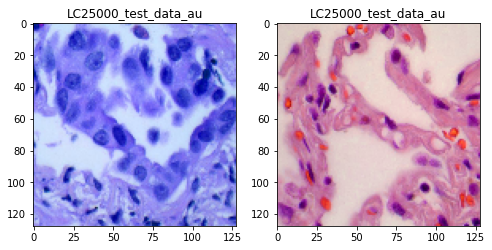

In [ ]:
# random show images
plt.subplots(1,2,figsize=(8,8))
ax1=plt.subplot(1,2,1)
sample1 = random.choice(LC25000_test_data_au)
img1 = array_to_img(sample1)
plt.title("LC25000_test_data_au")
plt.imshow(img1)
ax1=plt.subplot(1,2,2)
sample2 = random.choice(LC25000_test_data_au)
img2 = array_to_img(sample2)
plt.title("LC25000_test_data_au")
plt.imshow(img2)
plt.show

<function matplotlib.pyplot.show>

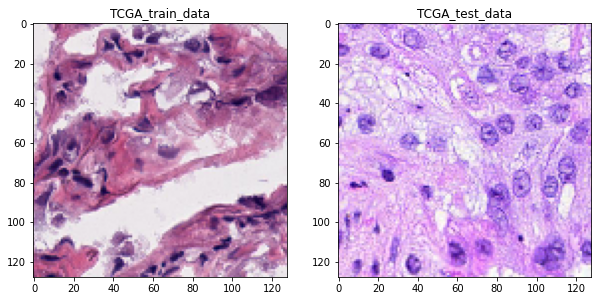

In [ ]:
# random show Target images
plt.subplots(1,2,figsize=(10,10))
ax1=plt.subplot(1,2,1)
sample1 = random.choice(TCGA_train_data)
img1 = array_to_img(sample1)
plt.title("TCGA_train_data")
plt.imshow(img1)
ax1=plt.subplot(1,2,2)
sample2 = random.choice(TCGA_test_data)
img2 = array_to_img(sample2)
plt.title("TCGA_test_data")
plt.imshow(img2)
plt.show

In [ ]:
#LC25000_train_data, LC25000_train_labels, TCGA_train_data, TCGA_train_labels

# Domain Adaptation

## Build Model

### Feature Extractor - VGG

In [ ]:
vgg =  VGG16(include_top=False, input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, CHANNELS), pooling="max")

first_layer = vgg.get_layer('block4_pool')
inputs = Input(first_layer.output_shape[1:])

# for layer in vgg.layers[vgg.layers.index(first_layer)+1:]:
#     x = layer(inputs)

for layer in vgg.layers[vgg.layers.index(first_layer)+1:]:
    if layer.name == "block5_conv1":
        x = layer(inputs)
    else:
        x = layer(x)
    # x = layer(inputs)

first_blocks = Model(vgg.input, first_layer.output)
last_block = Model(inputs, x)

In [ ]:
def load_vgg(path="./Model/DANN_Model/vgg_last_block_128.hdf5"):
    model = load_model(path)
    for i in range(len(model.layers)):
        if model.layers[i].__class__.__name__ == "BatchNormalization":
            model.layers[i].trainable = False
    return model

last_block.summary()
last_block.save("./Model/DANN_Model/vgg_last_block_128.hdf5")

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 8, 8, 512)]       0         
                                                                 
 block5_conv1 (Conv2D)       (None, 8, 8, 512)         2359808   
                                                                 
 block5_conv2 (Conv2D)       (None, 8, 8, 512)         2359808   
                                                                 
 block5_conv3 (Conv2D)       (None, 8, 8, 512)         2359808   
                                                                 
 block5_pool (MaxPooling2D)  (None, 4, 4, 512)         0         
                                                                 
 global_max_pooling2d (Globa  (None, 512)              0         
 lMaxPooling2D)                                                  
                                                           

### Extract the features 

In [ ]:
LC25000_train_data_au_ex = first_blocks.predict(preprocess_input(np.stack(LC25000_train_data_au)))
TCGA_train_data_ex = first_blocks.predict(preprocess_input(np.stack(TCGA_train_data)))

# one = OneHotEncoder(sparse=False)
# one.fit(np.array(LC25000_train_labels).reshape(-1, 1))

# LC25000_train_lab = one.transform(np.array(LC25000_train_labels).reshape(-1, 1))
# TCGA_train_lab = one.transform(np.array(TCGA_train_labels).reshape(-1, 1))

print("LC25000_train_data_au (source) shape: %s"%str(LC25000_train_data_au.shape))
print("TCGA_train_data (target) shape: %s"%str(TCGA_train_data.shape))

LC25000_train_data_au (source) shape: (6400, 128, 128, 3)
TCGA_train_data (target) shape: (6400, 128, 128, 3)


### Label Predictor

In [ ]:
def get_task(dropout=0.5, max_norm=0.5):
    model = Sequential()
    model.add(Dense(1024, activation="relu",
                   kernel_constraint=MaxNorm(max_norm),
                   bias_constraint=MaxNorm(max_norm)))
    model.add(Dropout(dropout))
    model.add(Dense(1024, activation="relu",
                   kernel_constraint=MaxNorm(max_norm),
                   bias_constraint=MaxNorm(max_norm)))
    model.add(Dropout(dropout))
    model.add(Dense(3, activation="softmax",
                   kernel_constraint=MaxNorm(max_norm),
                   bias_constraint=MaxNorm(max_norm)))
    return model

In [ ]:
class MyDecay(LearningRateSchedule):

    def __init__(self, max_steps=1000, mu_0=0.01, alpha=10, beta=0.75):
        self.mu_0 = mu_0
        self.alpha = alpha
        self.beta = beta
        self.max_steps = float(max_steps)

    def __call__(self, step):
        p = step / self.max_steps
        return self.mu_0 / (1+self.alpha * p)**self.beta

# Fit without adaptation

### Run 1


In [ ]:
lr = 1e-5
momentum = 0.9
alpha = 0.0002



optimizer_task = RMSprop(learning_rate=MyDecay(mu_0=lr, alpha=alpha),
                     momentum=momentum)
optimizer_enc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),
                    momentum=momentum)

In [ ]:
finetunig = FineTuning(encoder=load_vgg(),
                         task=get_task(),
                         optimizer=optimizer_task,
                         optimizer_enc=optimizer_enc,
                         loss="categorical_crossentropy",
                         metrics=["acc"],
                         copy=False,
                         pretrain=True,
                         pretrain__epochs=5)

In [ ]:
finetunig.fit(LC25000_train_data_au_ex, LC25000_train_lab, epochs=100, batch_size=64, validation_data=(TCGA_train_data_ex, TCGA_train_lab))

Epoch 1/5
100/100 [==============================] - 6s 29ms/step - loss: 1.2421 - acc: 0.8158 - val_loss: 1.5375 - val_acc: 0.4352
Epoch 2/5
100/100 [==============================] - 3s 25ms/step - loss: 0.2150 - acc: 0.9316 - val_loss: 2.7068 - val_acc: 0.4073
Epoch 3/5
100/100 [==============================] - 3s 25ms/step - loss: 0.2037 - acc: 0.9325 - val_loss: 2.4589 - val_acc: 0.4253
Epoch 4/5
100/100 [==============================] - 2s 25ms/step - loss: 0.1850 - acc: 0.9383 - val_loss: 2.8049 - val_acc: 0.4127
Epoch 5/5
100/100 [==============================] - 3s 26ms/step - loss: 0.1765 - acc: 0.9395 - val_loss: 3.1226 - val_acc: 0.4109
Epoch 1/100
100/100 [==============================] - 6s 35ms/step - loss: 0.1730 - acc: 0.9442 - val_loss: 3.8796 - val_acc: 0.4162
Epoch 2/100
100/100 [==============================] - 3s 31ms/step - loss: 0.1655 - acc: 0.9442 - val_loss: 4.1531 - val_acc: 0.4206
Epoch 3/100
100/100 [==============================] - 3s 31ms/step - lo

### Run 2


In [ ]:
lr = 1e-5
momentum = 0.9
alpha = 0.0002



optimizer_task = RMSprop(learning_rate=MyDecay(mu_0=lr, alpha=alpha),
                     momentum=momentum)
optimizer_enc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),
                    momentum=momentum)

In [ ]:
finetunig = FineTuning(encoder=load_vgg(),
                         task=get_task(),
                         optimizer=optimizer_task,
                         optimizer_enc=optimizer_enc,
                         loss="categorical_crossentropy",
                         metrics=["acc"],
                         copy=False,
                         pretrain=True,
                         pretrain__epochs=5)

In [ ]:
finetunig.fit(LC25000_train_data_au_ex, LC25000_train_lab, epochs=100, batch_size=64, validation_data=(TCGA_train_data_ex, TCGA_train_lab))

Epoch 1/5
100/100 [==============================] - 5s 25ms/step - loss: 0.9470 - acc: 0.8356 - val_loss: 1.7319 - val_acc: 0.4584
Epoch 2/5
100/100 [==============================] - 2s 20ms/step - loss: 0.2153 - acc: 0.9314 - val_loss: 2.6869 - val_acc: 0.4305
Epoch 3/5
100/100 [==============================] - 2s 20ms/step - loss: 0.2181 - acc: 0.9314 - val_loss: 2.7108 - val_acc: 0.4536
Epoch 4/5
100/100 [==============================] - 2s 20ms/step - loss: 0.2021 - acc: 0.9322 - val_loss: 2.8121 - val_acc: 0.4397
Epoch 5/5
100/100 [==============================] - 2s 20ms/step - loss: 0.1829 - acc: 0.9395 - val_loss: 3.1612 - val_acc: 0.4355
Epoch 1/100
100/100 [==============================] - 5s 34ms/step - loss: 0.1710 - acc: 0.9455 - val_loss: 3.6888 - val_acc: 0.4411
Epoch 2/100
100/100 [==============================] - 3s 28ms/step - loss: 0.1561 - acc: 0.9458 - val_loss: 3.6924 - val_acc: 0.4383
Epoch 3/100
100/100 [==============================] - 3s 28ms/step - lo

### Run 3


In [ ]:
lr = 1e-5
momentum = 0.9
alpha = 0.0002



optimizer_task = RMSprop(learning_rate=MyDecay(mu_0=lr, alpha=alpha),
                     momentum=momentum)
optimizer_enc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),
                    momentum=momentum)

In [ ]:
finetunig = FineTuning(encoder=load_vgg(),
                         task=get_task(),
                         optimizer=optimizer_task,
                         optimizer_enc=optimizer_enc,
                         loss="categorical_crossentropy",
                         metrics=["acc"],
                         copy=False,
                         pretrain=True,
                         pretrain__epochs=5)

In [ ]:
finetunig.fit(LC25000_train_data_au_ex, LC25000_train_lab, epochs=100, batch_size=64, validation_data=(TCGA_train_data_ex, TCGA_train_lab))

Epoch 1/5
100/100 [==============================] - 3s 27ms/step - loss: 0.7944 - acc: 0.8491 - val_loss: 2.3394 - val_acc: 0.4530
Epoch 2/5
100/100 [==============================] - 2s 21ms/step - loss: 0.2587 - acc: 0.9219 - val_loss: 2.7285 - val_acc: 0.4437
Epoch 3/5
100/100 [==============================] - 2s 21ms/step - loss: 0.2061 - acc: 0.9353 - val_loss: 2.9846 - val_acc: 0.4347
Epoch 4/5
100/100 [==============================] - 2s 21ms/step - loss: 0.1753 - acc: 0.9409 - val_loss: 3.2511 - val_acc: 0.4352
Epoch 5/5
100/100 [==============================] - 2s 21ms/step - loss: 0.1618 - acc: 0.9452 - val_loss: 3.5824 - val_acc: 0.4333
Epoch 1/100
100/100 [==============================] - 4s 34ms/step - loss: 0.1548 - acc: 0.9497 - val_loss: 4.4807 - val_acc: 0.4423
Epoch 2/100
100/100 [==============================] - 3s 28ms/step - loss: 0.1551 - acc: 0.9450 - val_loss: 4.1018 - val_acc: 0.4536
Epoch 3/100
100/100 [==============================] - 3s 28ms/step - lo

KeyboardInterrupt: ignored

### Run 4


In [ ]:
lr = 1e-5
momentum = 0.9
alpha = 0.0002



optimizer_task = RMSprop(learning_rate=MyDecay(mu_0=lr, alpha=alpha),
                     momentum=momentum)
optimizer_enc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),
                    momentum=momentum)

In [ ]:
finetunig = FineTuning(encoder=load_vgg(),
                         task=get_task(),
                         optimizer=optimizer_task,
                         optimizer_enc=optimizer_enc,
                         loss="categorical_crossentropy",
                         metrics=["acc"],
                         copy=False,
                         pretrain=True,
                         pretrain__epochs=5)

In [ ]:
finetunig.fit(LC25000_train_data_au_ex, LC25000_train_lab, epochs=100, batch_size=64, validation_data=(TCGA_train_data_ex, TCGA_train_lab))

Epoch 1/5
100/100 [==============================] - 4s 27ms/step - loss: 0.9939 - acc: 0.8317 - val_loss: 2.1118 - val_acc: 0.4209
Epoch 2/5
100/100 [==============================] - 2s 22ms/step - loss: 0.2355 - acc: 0.9255 - val_loss: 2.9859 - val_acc: 0.4191
Epoch 3/5
100/100 [==============================] - 2s 22ms/step - loss: 0.2206 - acc: 0.9320 - val_loss: 2.6841 - val_acc: 0.4281
Epoch 4/5
100/100 [==============================] - 2s 22ms/step - loss: 0.1978 - acc: 0.9378 - val_loss: 3.0836 - val_acc: 0.4327
Epoch 5/5
100/100 [==============================] - 2s 22ms/step - loss: 0.1784 - acc: 0.9372 - val_loss: 3.3552 - val_acc: 0.4320
Epoch 1/100
100/100 [==============================] - 5s 33ms/step - loss: 0.1748 - acc: 0.9428 - val_loss: 4.4707 - val_acc: 0.4062
Epoch 2/100
100/100 [==============================] - 3s 29ms/step - loss: 0.1549 - acc: 0.9447 - val_loss: 4.2553 - val_acc: 0.4236
Epoch 3/100
100/100 [==============================] - 3s 28ms/step - lo

### Run 5


In [ ]:
lr = 1e-5
momentum = 0.9
alpha = 0.0002



optimizer_task = RMSprop(learning_rate=MyDecay(mu_0=lr, alpha=alpha),
                     momentum=momentum)
optimizer_enc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),
                    momentum=momentum)

In [ ]:
finetunig = FineTuning(encoder=load_vgg(),
                         task=get_task(),
                         optimizer=optimizer_task,
                         optimizer_enc=optimizer_enc,
                         loss="categorical_crossentropy",
                         metrics=["acc"],
                         copy=False,
                         pretrain=True,
                         pretrain__epochs=5)

In [ ]:
finetunig.fit(LC25000_train_data_au_ex, LC25000_train_lab, epochs=100, batch_size=64, validation_data=(TCGA_train_data_ex, TCGA_train_lab))

Epoch 1/5
100/100 [==============================] - 3s 24ms/step - loss: 0.7058 - acc: 0.8592 - val_loss: 2.6477 - val_acc: 0.4477
Epoch 2/5
100/100 [==============================] - 2s 20ms/step - loss: 0.2845 - acc: 0.9153 - val_loss: 2.5197 - val_acc: 0.4241
Epoch 3/5
100/100 [==============================] - 2s 21ms/step - loss: 0.1745 - acc: 0.9420 - val_loss: 3.0618 - val_acc: 0.4512
Epoch 4/5
100/100 [==============================] - 2s 21ms/step - loss: 0.1927 - acc: 0.9344 - val_loss: 3.1619 - val_acc: 0.4397
Epoch 5/5
100/100 [==============================] - 2s 21ms/step - loss: 0.1735 - acc: 0.9403 - val_loss: 3.3009 - val_acc: 0.4459
Epoch 1/100
100/100 [==============================] - 5s 33ms/step - loss: 0.1680 - acc: 0.9453 - val_loss: 3.8671 - val_acc: 0.4320
Epoch 2/100
100/100 [==============================] - 3s 28ms/step - loss: 0.1382 - acc: 0.9506 - val_loss: 4.0436 - val_acc: 0.4350
Epoch 3/100
100/100 [==============================] - 3s 28ms/step - lo

### Result

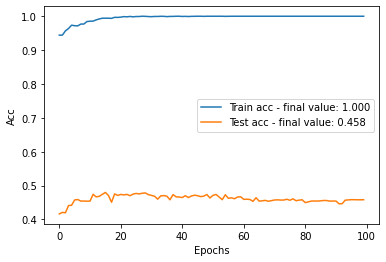

In [ ]:
acc = finetunig.history.history["acc"]; val_acc = finetunig.history.history["val_acc"]
plt.plot(acc, label="Train acc - final value: %.3f"%acc[-1])
plt.plot(val_acc, label="Test acc - final value: %.3f"%val_acc[-1])
plt.legend(); plt.xlabel("Epochs"); plt.ylabel("Acc"); plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


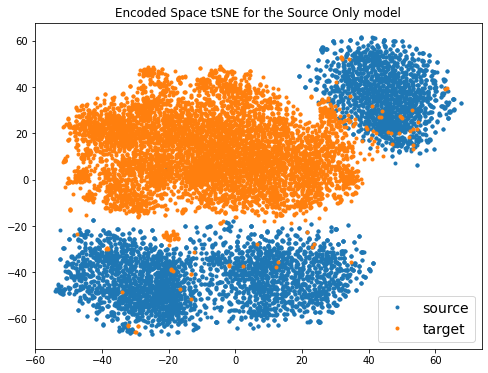

In [ ]:
LC25000_train_data_au_enc = finetunig.transform(LC25000_train_data_au_ex)
TCGA_train_data_enc = finetunig.transform(TCGA_train_data_ex)

np.random.seed(0)
X_ = np.concatenate((LC25000_train_data_au_enc, TCGA_train_data_enc))
X_tsne = TSNE(2).fit_transform(X_)
plt.figure(figsize=(8, 6))
plt.plot(X_tsne[:len(LC25000_train_data_au_ex), 0], X_tsne[:len(LC25000_train_data_au_ex), 1], '.', label="source")
plt.plot(X_tsne[len(LC25000_train_data_au_ex):, 0], X_tsne[len(LC25000_train_data_au_ex):, 1], '.', label="target")
plt.legend(fontsize=14)
plt.title("Encoded Space tSNE for the Source Only model")
plt.show()

In [ ]:
# convert the history.history dictionary to a pandas dataframe:     
hist_df = pd.DataFrame(finetunig.history.history) 

# or the describe() method:
hist_df.describe()

,loss,acc,val_loss,val_acc
count,1.000000e+02,100.000000,100.000000,100.000000
mean,1.310579e-02,0.995680,12.454835,0.461014
std,3.274515e-02,0.010968,3.017114,0.011317
min,3.401092e-07,0.944219,3.879589,0.416250
25%,3.564867e-06,0.998906,12.010063,0.455195
50%,1.496154e-04,1.000000,13.930124,0.459375
75%,2.966458e-03,1.000000,14.452113,0.470000
max,1.730124e-01,1.000000,15.217443,0.479688


In [ ]:
hist_df.to_csv("./Model/DANN_Model/MDD_128/MDD_source_VGG_128_RMS_1e-5_AU.csv")

# Fit with adaptation

### Run 1

In [ ]:
lr = 1e-5
momentum = 0.9
alpha = 0.0002


encoder = load_vgg()
task = get_task()

# optimizer_task = Adam(learning_rate=MyDecay(mu_0=lr, alpha=alpha))
# optimizer_enc = Adam(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha))
# optimizer_disc = Adam(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha))
optimizer_task = RMSprop(learning_rate=MyDecay(mu_0=lr, alpha=alpha),
                     momentum=momentum)
optimizer_enc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),
                    momentum=momentum)
optimizer_disc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),
                    momentum=momentum)

In [ ]:
mdd = MDD(encoder, task,
            loss="categorical_crossentropy",
            metrics=["acc"],
            copy=False,
            lambda_=tf.Variable(0.),
            gamma=1.,
            optimizer=optimizer_task,
            optimizer_enc=optimizer_enc,
            optimizer_disc=optimizer_disc,
            callbacks=[UpdateLambda(lambda_max=0.1)])

In [ ]:
mdd.fit(X=LC25000_train_data_au_ex[:-1], y=LC25000_train_lab[:-1], Xt=TCGA_train_data_ex, epochs=200, batch_size=64,  validation_data=(TCGA_train_data_ex, TCGA_train_lab))

Epoch 1/200
100/100 [==============================] - 10s 49ms/step - loss: 0.6896 - acc: 0.8459 - disc_loss: 2.0140 - val_loss: 1.4000 - val_acc: 0.4255
Epoch 2/200
100/100 [==============================] - 4s 42ms/step - loss: 0.1568 - acc: 0.9453 - disc_loss: 1.3571 - val_loss: 2.3214 - val_acc: 0.4252
Epoch 3/200
100/100 [==============================] - 4s 41ms/step - loss: 0.1282 - acc: 0.9584 - disc_loss: 1.2165 - val_loss: 3.4789 - val_acc: 0.4466
Epoch 4/200
100/100 [==============================] - 4s 42ms/step - loss: 0.1011 - acc: 0.9653 - disc_loss: 1.0935 - val_loss: 4.3860 - val_acc: 0.4256
Epoch 5/200
100/100 [==============================] - 4s 42ms/step - loss: 0.0986 - acc: 0.9691 - disc_loss: 1.0376 - val_loss: 4.8690 - val_acc: 0.4359
Epoch 6/200
100/100 [==============================] - 4s 42ms/step - loss: 0.0901 - acc: 0.9723 - disc_loss: 1.0779 - val_loss: 5.1819 - val_acc: 0.4505
Epoch 7/200
100/100 [==============================] - 4s 42ms/step - loss:

### Run 2

In [ ]:
lr = 1e-5
momentum = 0.9
alpha = 0.0002


encoder = load_vgg()
task = get_task()

optimizer_task = RMSprop(learning_rate=MyDecay(mu_0=lr, alpha=alpha),
                     momentum=momentum)
optimizer_enc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),
                    momentum=momentum)
optimizer_disc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),
                    momentum=momentum)

In [ ]:
mdd = MDD(encoder, task,
            loss="categorical_crossentropy",
            metrics=["acc"],
            copy=False,
            lambda_=tf.Variable(0.),
            gamma=1.,
            optimizer=optimizer_task,
            optimizer_enc=optimizer_enc,
            optimizer_disc=optimizer_disc,
            callbacks=[UpdateLambda(lambda_max=0.1)])

In [ ]:
mdd.fit(X=LC25000_train_data_au_ex[:-1], y=LC25000_train_lab[:-1], Xt=TCGA_train_data_ex, epochs=200, batch_size=64,  validation_data=(TCGA_train_data_ex, TCGA_train_lab))

Epoch 1/200
100/100 [==============================] - 7s 49ms/step - loss: 1.1012 - acc: 0.7819 - disc_loss: 1.9644 - val_loss: 1.3104 - val_acc: 0.4367
Epoch 2/200
100/100 [==============================] - 4s 42ms/step - loss: 0.1998 - acc: 0.9308 - disc_loss: 1.3078 - val_loss: 1.7296 - val_acc: 0.4291
Epoch 3/200
100/100 [==============================] - 4s 42ms/step - loss: 0.1414 - acc: 0.9539 - disc_loss: 1.1037 - val_loss: 2.2863 - val_acc: 0.4302
Epoch 4/200
100/100 [==============================] - 4s 42ms/step - loss: 0.1032 - acc: 0.9653 - disc_loss: 0.9928 - val_loss: 3.4302 - val_acc: 0.4523
Epoch 5/200
100/100 [==============================] - 4s 42ms/step - loss: 0.0898 - acc: 0.9692 - disc_loss: 0.9220 - val_loss: 3.9519 - val_acc: 0.4502
Epoch 6/200
100/100 [==============================] - 4s 42ms/step - loss: 0.0800 - acc: 0.9731 - disc_loss: 0.9587 - val_loss: 4.0827 - val_acc: 0.4589
Epoch 7/200
100/100 [==============================] - 4s 41ms/step - loss: 

### Run 3

In [ ]:
lr = 1e-5
momentum = 0.9
alpha = 0.0002


encoder = load_vgg()
task = get_task()

# optimizer_task = Adam(learning_rate=MyDecay(mu_0=lr, alpha=alpha))
# optimizer_enc = Adam(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha))
# optimizer_disc = Adam(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha))
optimizer_task = RMSprop(learning_rate=MyDecay(mu_0=lr, alpha=alpha),
                     momentum=momentum)
optimizer_enc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),
                    momentum=momentum)
optimizer_disc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),
                    momentum=momentum)

In [ ]:
mdd = MDD(encoder, task,
            loss="categorical_crossentropy",
            metrics=["acc"],
            copy=False,
            lambda_=tf.Variable(0.),
            gamma=1.,
            optimizer=optimizer_task,
            optimizer_enc=optimizer_enc,
            optimizer_disc=optimizer_disc,
            callbacks=[UpdateLambda(lambda_max=0.1)])

In [ ]:
mdd.fit(X=LC25000_train_data_au_ex[:-1], y=LC25000_train_lab[:-1], Xt=TCGA_train_data_ex, epochs=200, batch_size=64,  validation_data=(TCGA_train_data_ex, TCGA_train_lab))

Epoch 1/200
100/100 [==============================] - 7s 47ms/step - loss: 1.4578 - acc: 0.7709 - disc_loss: 1.9683 - val_loss: 1.3937 - val_acc: 0.4416
Epoch 2/200
100/100 [==============================] - 4s 41ms/step - loss: 0.1743 - acc: 0.9452 - disc_loss: 1.2958 - val_loss: 1.9320 - val_acc: 0.4205
Epoch 3/200
100/100 [==============================] - 4s 41ms/step - loss: 0.1305 - acc: 0.9588 - disc_loss: 1.0734 - val_loss: 2.6375 - val_acc: 0.4487
Epoch 4/200
100/100 [==============================] - 4s 41ms/step - loss: 0.0974 - acc: 0.9675 - disc_loss: 0.9850 - val_loss: 3.6064 - val_acc: 0.4350
Epoch 5/200
100/100 [==============================] - 4s 42ms/step - loss: 0.0921 - acc: 0.9684 - disc_loss: 0.9445 - val_loss: 3.8372 - val_acc: 0.4391
Epoch 6/200
100/100 [==============================] - 4s 41ms/step - loss: 0.1065 - acc: 0.9680 - disc_loss: 1.1275 - val_loss: 3.1233 - val_acc: 0.4911
Epoch 7/200
100/100 [==============================] - 4s 41ms/step - loss: 

### Run 4

In [ ]:
lr = 1e-5
momentum = 0.9
alpha = 0.0002


encoder = load_vgg()
task = get_task()

optimizer_task = RMSprop(learning_rate=MyDecay(mu_0=lr, alpha=alpha),
                     momentum=momentum)
optimizer_enc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),
                    momentum=momentum)
optimizer_disc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),
                    momentum=momentum)

In [ ]:
mdd = MDD(encoder, task,
            loss="categorical_crossentropy",
            metrics=["acc"],
            copy=False,
            lambda_=tf.Variable(0.),
            gamma=1.,
            optimizer=optimizer_task,
            optimizer_enc=optimizer_enc,
            optimizer_disc=optimizer_disc,
            callbacks=[UpdateLambda(lambda_max=0.1)])

In [ ]:
mdd.fit(X=LC25000_train_data_au_ex[:-1], y=LC25000_train_lab[:-1], Xt=TCGA_train_data_ex, epochs=200, batch_size=64,  validation_data=(TCGA_train_data_ex, TCGA_train_lab))

Epoch 1/200
100/100 [==============================] - 7s 49ms/step - loss: 0.9251 - acc: 0.8166 - disc_loss: 2.0125 - val_loss: 1.2642 - val_acc: 0.4284
Epoch 2/200
100/100 [==============================] - 4s 42ms/step - loss: 0.1943 - acc: 0.9331 - disc_loss: 1.2766 - val_loss: 1.9737 - val_acc: 0.4311
Epoch 3/200
100/100 [==============================] - 4s 42ms/step - loss: 0.1368 - acc: 0.9545 - disc_loss: 1.1520 - val_loss: 3.0824 - val_acc: 0.4425
Epoch 4/200
100/100 [==============================] - 4s 42ms/step - loss: 0.1084 - acc: 0.9673 - disc_loss: 0.9777 - val_loss: 3.7161 - val_acc: 0.4441
Epoch 5/200
100/100 [==============================] - 4s 42ms/step - loss: 0.0933 - acc: 0.9702 - disc_loss: 0.9457 - val_loss: 4.2350 - val_acc: 0.4452
Epoch 6/200
100/100 [==============================] - 4s 42ms/step - loss: 0.0809 - acc: 0.9747 - disc_loss: 1.0709 - val_loss: 5.3449 - val_acc: 0.4441
Epoch 7/200
100/100 [==============================] - 4s 42ms/step - loss: 

### Run 5

In [ ]:
lr = 1e-5
momentum = 0.9
alpha = 0.0002

encoder = load_vgg()
task = get_task()

optimizer_task = RMSprop(learning_rate=MyDecay(mu_0=lr, alpha=alpha),
                     momentum=momentum)
optimizer_enc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),
                    momentum=momentum)
optimizer_disc = RMSprop(learning_rate=MyDecay(mu_0=lr/10., alpha=alpha),
                    momentum=momentum)

In [ ]:
mdd = MDD(encoder, task,
            loss="categorical_crossentropy",
            metrics=["acc"],
            copy=False,
            lambda_=tf.Variable(0.),
            gamma=1.,
            optimizer=optimizer_task,
            optimizer_enc=optimizer_enc,
            optimizer_disc=optimizer_disc,
            callbacks=[UpdateLambda(lambda_max=0.1)])

In [ ]:
mdd.fit(X=LC25000_train_data_au_ex[:-1], y=LC25000_train_lab[:-1], Xt=TCGA_train_data_ex, epochs=200, batch_size=64,  validation_data=(TCGA_train_data_ex, TCGA_train_lab))

Epoch 1/200
100/100 [==============================] - 7s 49ms/step - loss: 0.8433 - acc: 0.8292 - disc_loss: 2.0481 - val_loss: 1.3874 - val_acc: 0.4416
Epoch 2/200
100/100 [==============================] - 4s 42ms/step - loss: 0.1766 - acc: 0.9428 - disc_loss: 1.2930 - val_loss: 2.0048 - val_acc: 0.4327
Epoch 3/200
100/100 [==============================] - 4s 42ms/step - loss: 0.1250 - acc: 0.9588 - disc_loss: 1.1136 - val_loss: 2.6088 - val_acc: 0.4373
Epoch 4/200
100/100 [==============================] - 4s 41ms/step - loss: 0.1179 - acc: 0.9609 - disc_loss: 1.0518 - val_loss: 3.7541 - val_acc: 0.4273
Epoch 5/200
100/100 [==============================] - 4s 41ms/step - loss: 0.1059 - acc: 0.9667 - disc_loss: 1.0371 - val_loss: 4.4693 - val_acc: 0.4263
Epoch 6/200
100/100 [==============================] - 4s 41ms/step - loss: 0.0966 - acc: 0.9691 - disc_loss: 1.1128 - val_loss: 6.0463 - val_acc: 0.4084
Epoch 7/200
100/100 [==============================] - 4s 41ms/step - loss: 

### Result

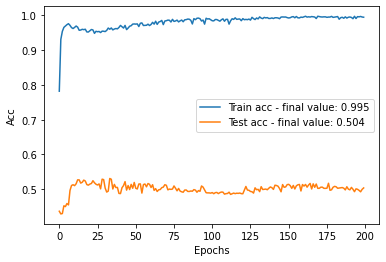

In [ ]:
acc = mdd.history.history["acc"]; val_acc = mdd.history.history["val_acc"]
plt.plot(acc, label="Train acc - final value: %.3f"%acc[-1])
plt.plot(val_acc, label="Test acc - final value: %.3f"%val_acc[-1])
plt.legend(); plt.xlabel("Epochs"); plt.ylabel("Acc"); plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


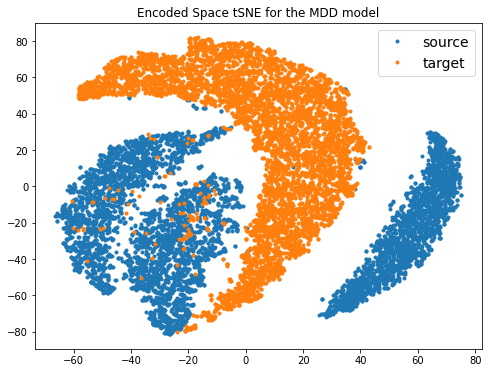

In [ ]:
LC25000_train_data_au_enc = mdd.transform(LC25000_train_data_au_ex)
TCGA_train_data_enc = mdd.transform(TCGA_train_data_ex)

np.random.seed(0)
X_ = np.concatenate((LC25000_train_data_au_enc, TCGA_train_data_enc))
X_tsne = TSNE(2).fit_transform(X_)
plt.figure(figsize=(8, 6))
plt.plot(X_tsne[:len(LC25000_train_data_au_ex), 0], X_tsne[:len(LC25000_train_data_au_ex), 1], '.', label="source")
plt.plot(X_tsne[len(LC25000_train_data_au_ex):, 0], X_tsne[len(LC25000_train_data_au_ex):, 1], '.', label="target")
plt.legend(fontsize=14)
plt.title("Encoded Space tSNE for the MDD model")
plt.show()

In [ ]:
# convert the history.history dictionary to a pandas dataframe:     
hist_df = pd.DataFrame(mdd.history.history) 

# or the describe() method:
hist_df.describe()

,loss,acc,disc_loss,val_loss,val_acc
count,200.000000,200.000000,200.000000,200.000000,200.000000
mean,0.079696,0.980938,12.826283,13.859104,0.501184
std,0.091186,0.019880,3.218581,8.314238,0.014936
min,0.012257,0.781875,0.748478,1.216442,0.429062
25%,0.032645,0.971367,12.886193,4.836286,0.494180
50%,0.052983,0.987500,13.696767,16.027740,0.502422
75%,0.111200,0.992969,14.330104,19.916179,0.510664
max,1.101218,0.997344,16.177061,30.939888,0.530937


In [ ]:
hist_df.to_csv("./Model/DANN_Model/MDD_128/MDD_VGG_128_RMS_ 1e-5_g1_AU.csv")

In [ ]:
import gc
gc.collect()

6888